# HMM model knowledge
Blog: <https://blog.csdn.net/ebzxw/article/details/80465399>

## 输入输出
- 输入：
    - 隐藏状态数目
    - 输入的观测变量
    - 混合高斯分布成分数目
- 输出：
    - 每个时刻对应的状态序列
    - 混合分布的均值和方差矩阵
    - 混合分布的权重矩阵
    - 状态间转移概率矩阵


# Read data and procecss

In [1]:
# import 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hmmlearn.hmm as hmm


In [14]:
# Read data
n=3#状态数
data=pd.read_csv('../data/SSE.csv')
volume=data['vol']
close=data['close']

# 对数差分
# Delta = np.array(data['high']) - np.array(data['low'])
# Del stands for Delta
logDel = np.log(np.array(data['high'])) - np.log(np.array(data['low']))
logRet_1 = np.array(np.diff(np.log(close)))
logRet_5 = np.log(np.array(close[5:])) - np.log(np.array(close[:-5]))
logVol_5 = np.log(np.array(volume[5:])) - np.log(np.array(volume[:-5]))

# 保持所有的数据shape相同
logDel = logDel[5:]
logRet_1 = logRet_1[4:]
close = close[5:]
#将行数合并
data['date_time'] = pd.to_datetime(data['trade_date'], format='%Y%m%d')
Date = pd.to_datetime(data['date_time'][5:])
# print(Date)
# print(logDel.shape)
# print(logRet_5.shape)
# print(logVol_5.shape)
A = np.column_stack([logDel, logRet_5, logVol_5])
#model=hmm.GaussianHMM()


# HMM model

In [15]:
model = hmm.GaussianHMM(n_components=n, covariance_type="full", n_iter=2000).fit(A)
hidden_states = model.predict(A)

/home/zuohaolan/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


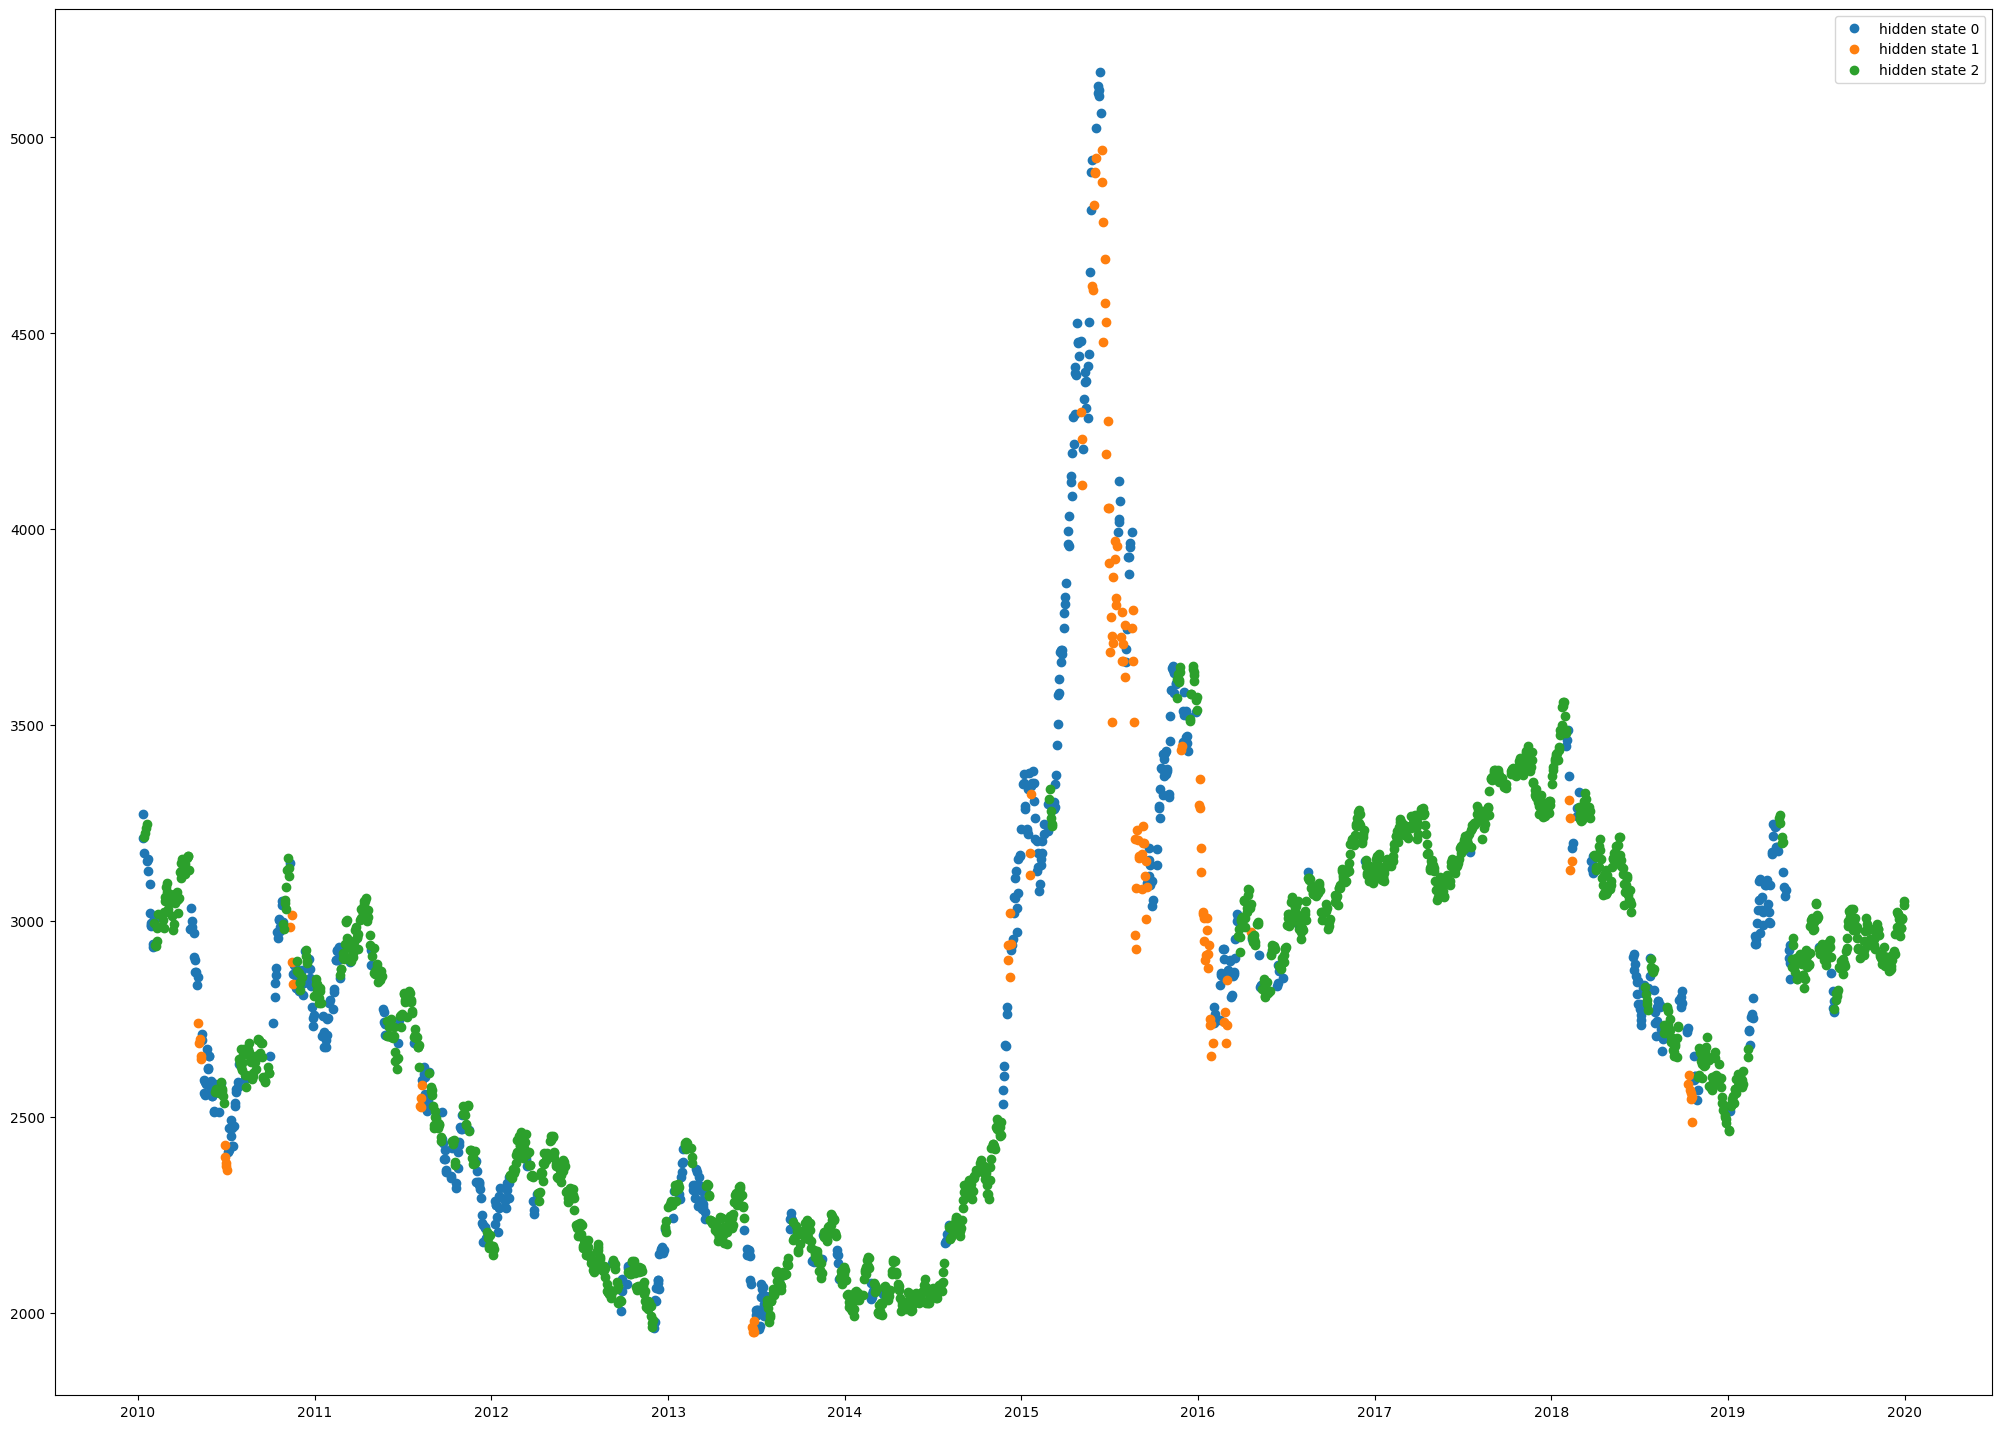

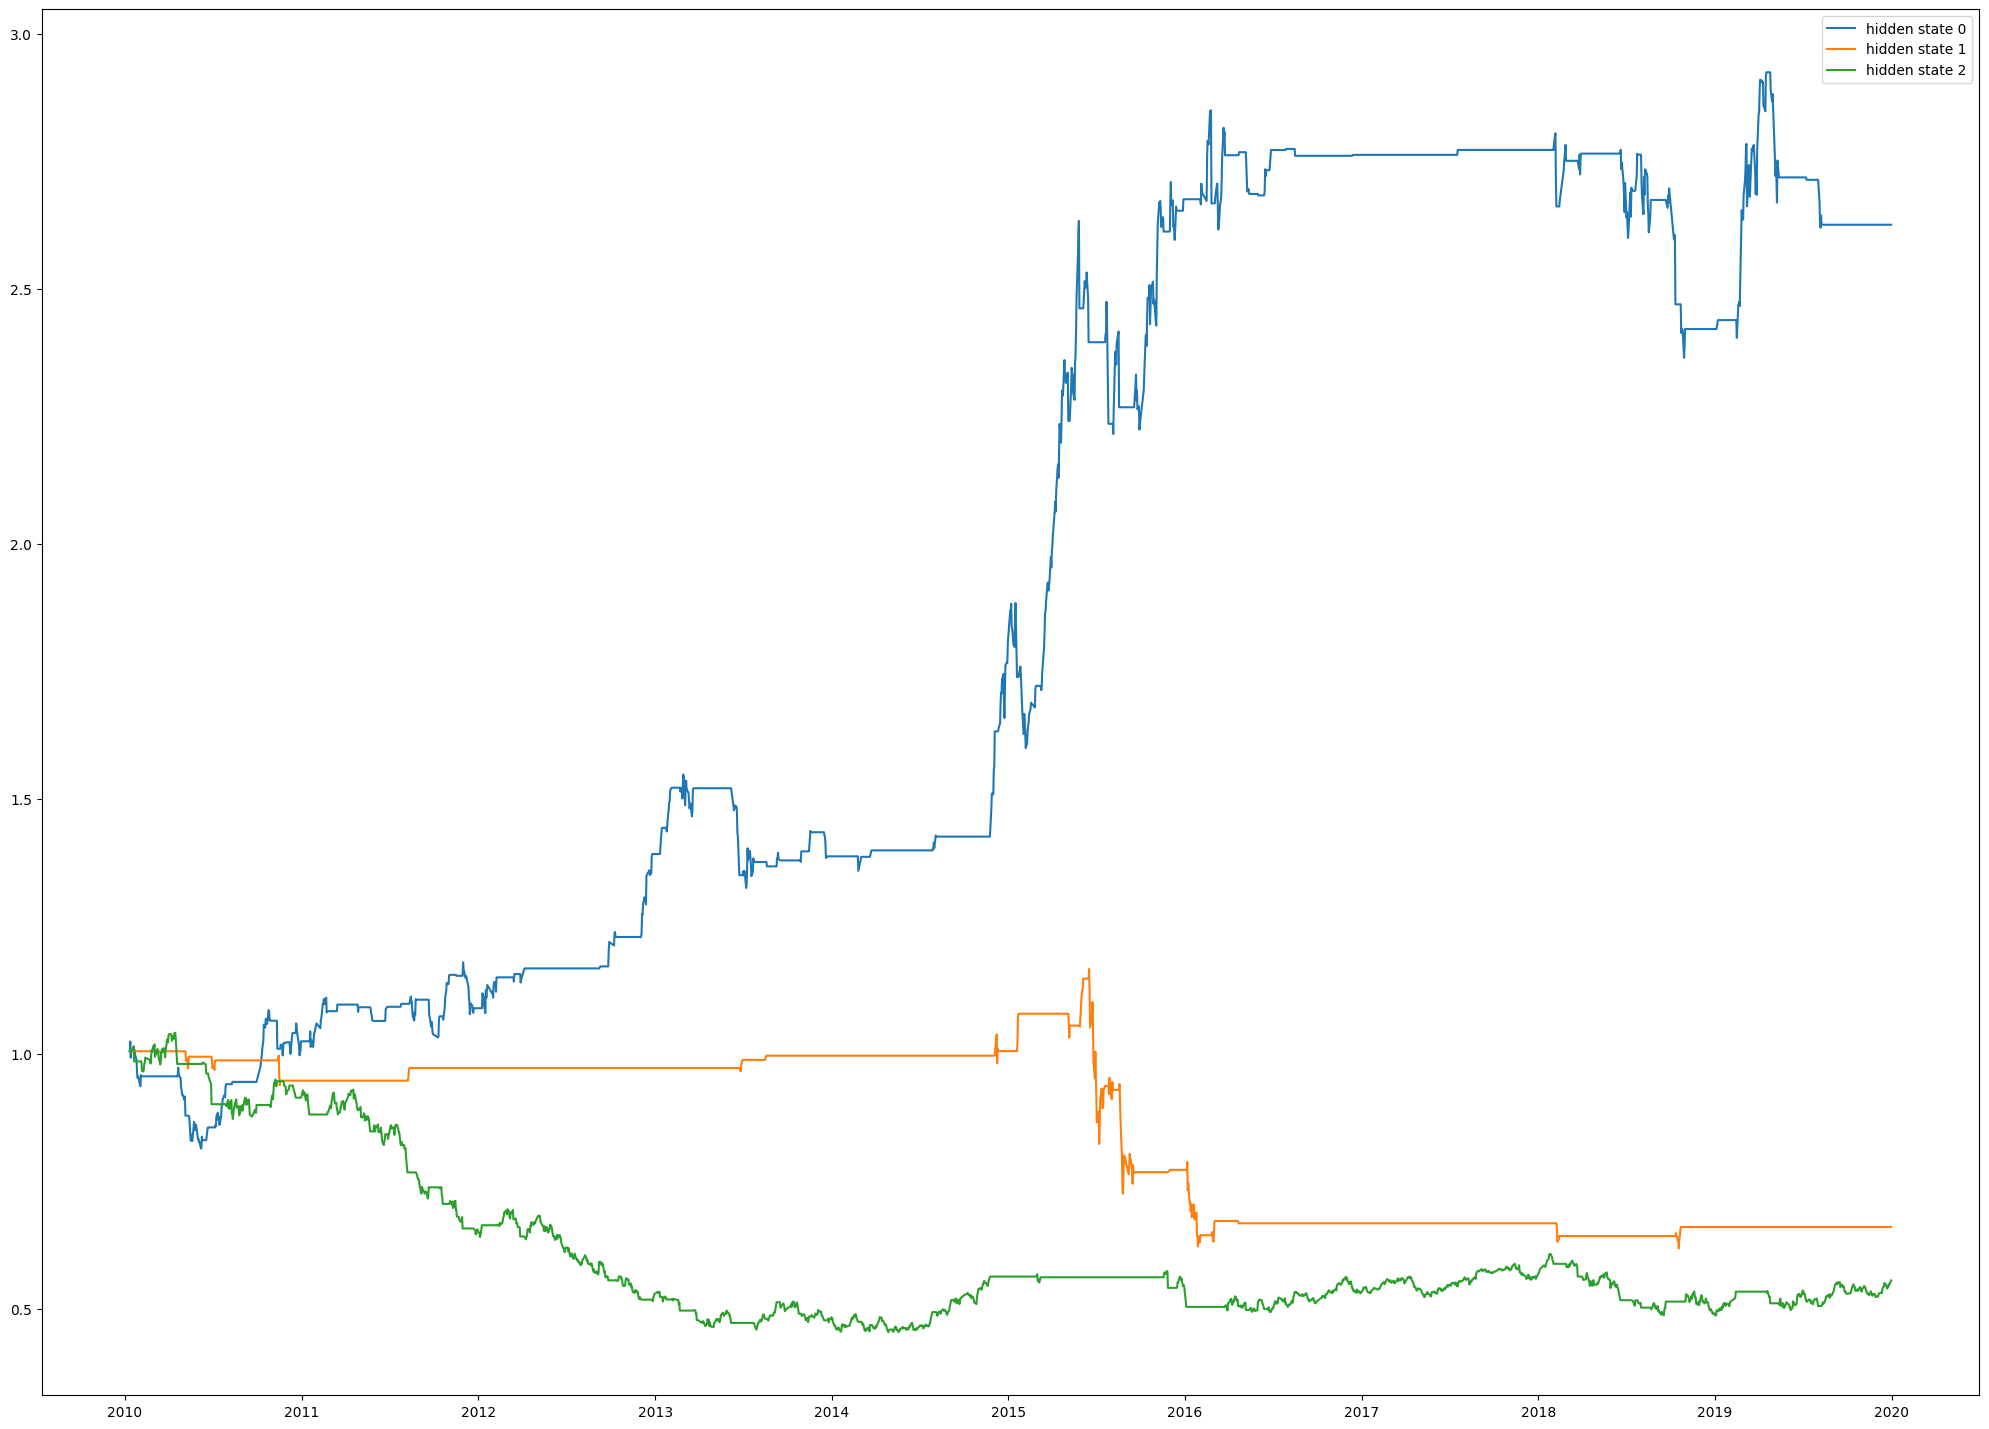

In [16]:
plt.figure(figsize=(25, 18))
for i in range(n):
    pos = (hidden_states == i)
    plt.plot_date(Date[pos], close[pos], 'o', label='hidden state %d' % i, lw=2)
    plt.legend()
plt.show()

res = pd.DataFrame({'Date': Date, 'logReg_1': logRet_1, 'state': hidden_states}).set_index('Date')
series = res.logReg_1

templist = []
plt.figure(figsize=(25, 18))
for i in range(n):
    pos = (hidden_states == i)
    pos = np.append(1, pos[:-1])
    res['state_ret%d' % i] = series.multiply(pos)
    data_i = np.exp(res['state_ret%d' % i].cumsum())
    templist.append(data_i[-1])
    plt.plot_date(Date, data_i, '-', label='hidden state %d' % i)
    plt.legend()
plt.show()

# Backtest

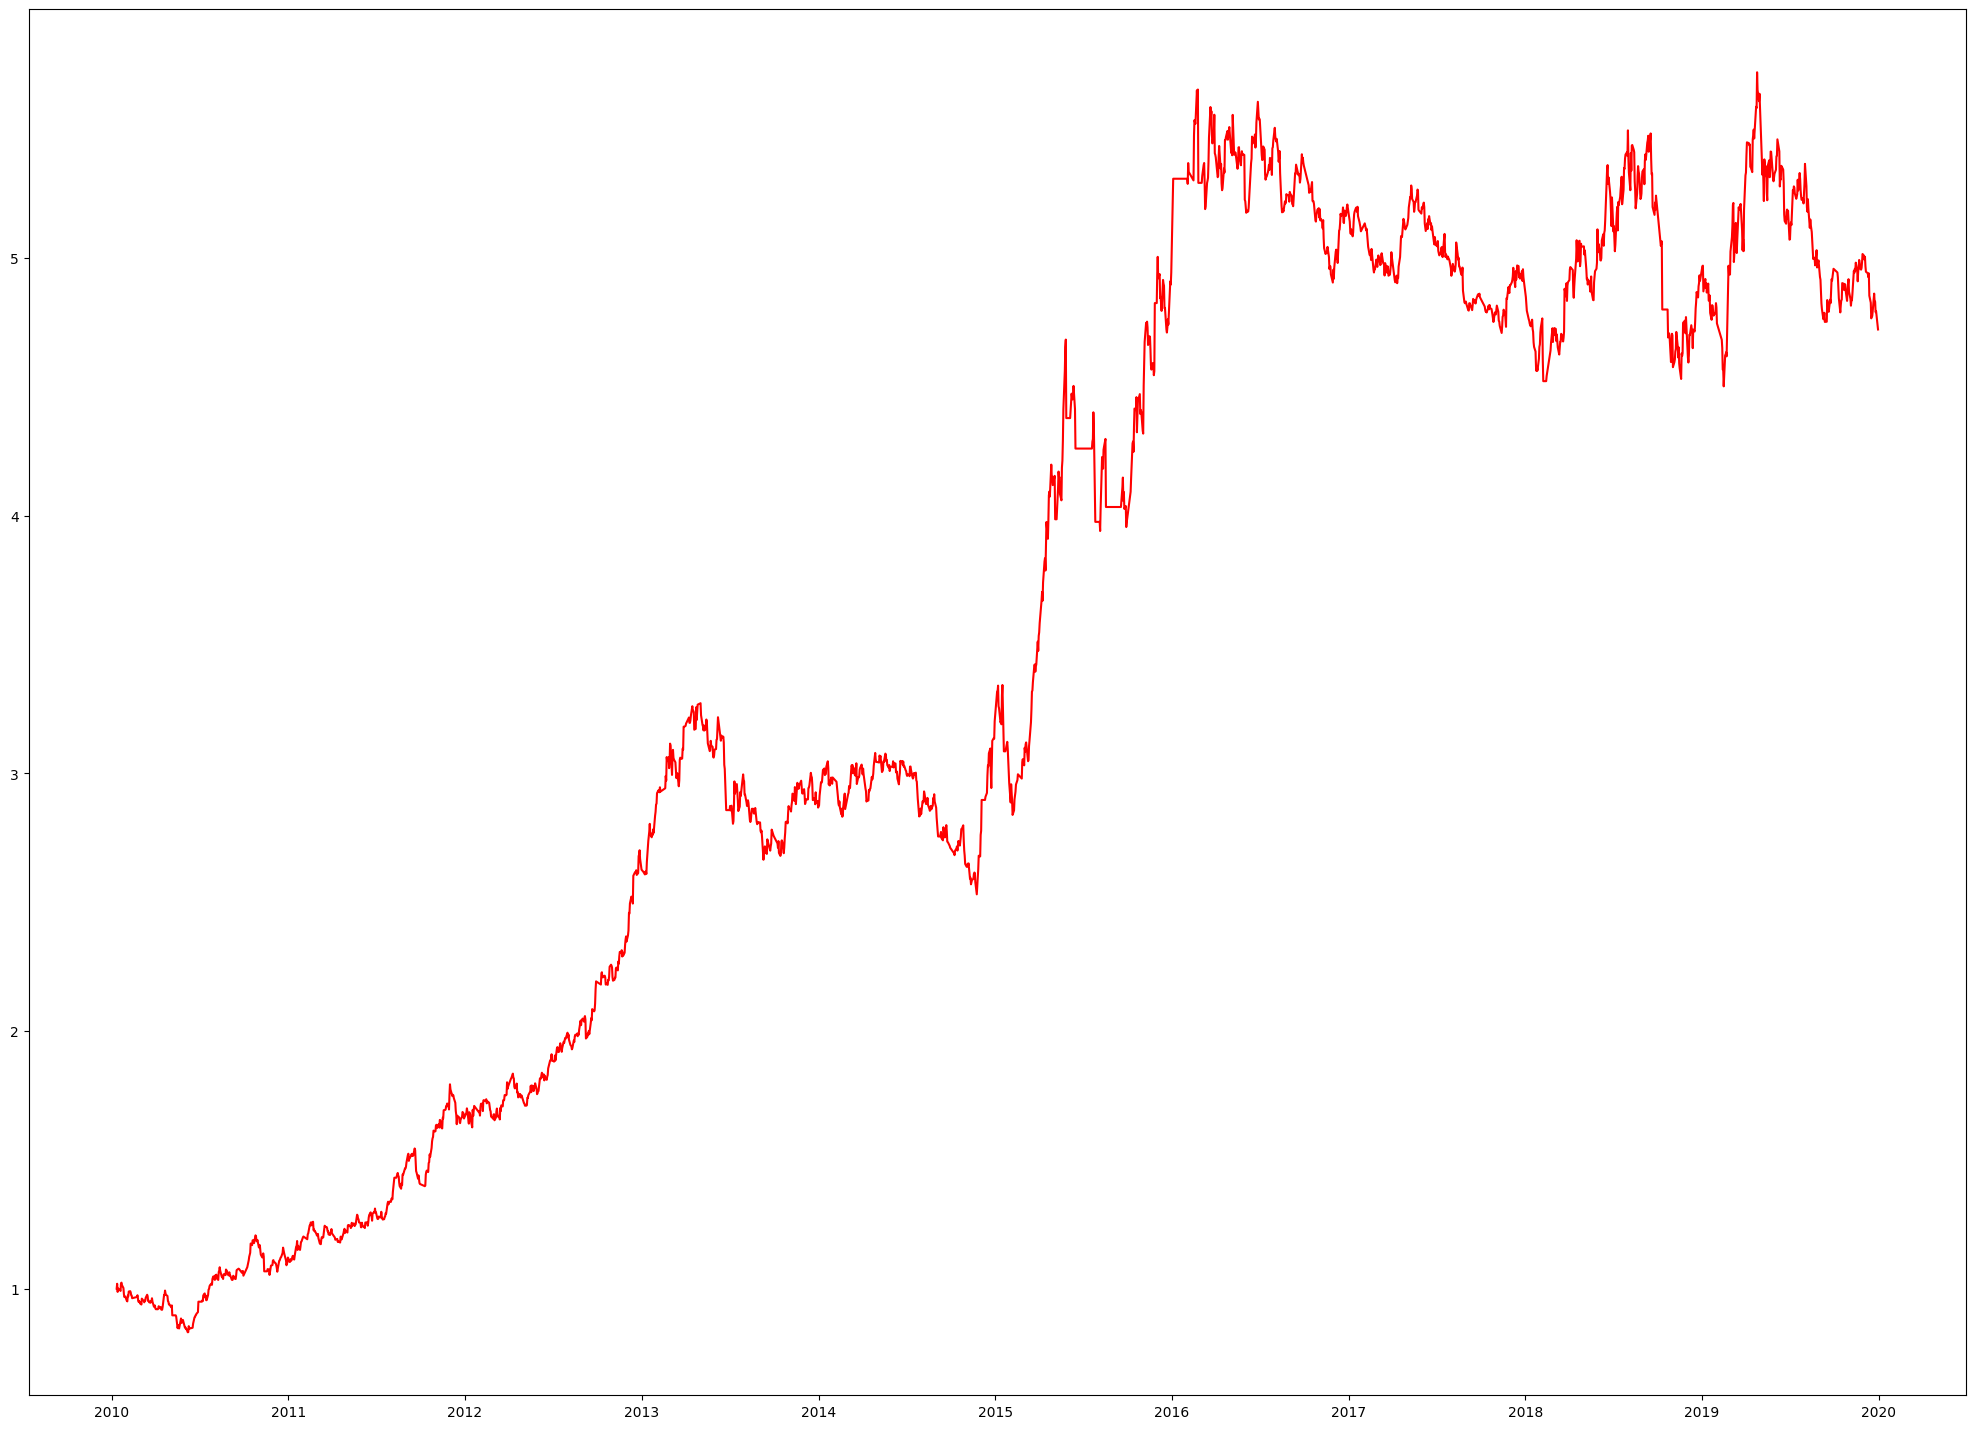

In [17]:
templist = np.array(templist).argsort()
long = (hidden_states == templist[-1]) + (hidden_states == templist[-2])  # 买入
short = (hidden_states == templist[0]) + (hidden_states == templist[1])  # 卖出
long = np.append(0, long[:-1])
short = np.append(0, short[:-1])

plt.figure(figsize=(25, 18))
res['ret'] = series.multiply(long) - series.multiply(short)
plt.plot_date(Date, np.exp(res['ret'].cumsum()), 'r-')
plt.show()